In [ ]:
# Run if you want to get rid of water, leave only protein and make the molecules whole
! echo 16 | gmx trjconv -f ../dynamic.xtc -s ../dynamic.tpr -o vars/unwrapped_no_water.xtc -pbc nojump -n index.ndx -skip 10 # make the molecules whole again!
! echo 16 | gmx trjconv -f ../dynamic.gro -s ../dynamic.tpr -o vars/unwrapped_no_water.gro -pbc nojump -n index.ndx

cat: write error: Broken pipe
               :-) GROMACS - gmx trjconv, 2024.2-conda_forge (-:

Executable:   /opt/conda/envs/gromacs/bin.AVX2_256/gmx
Data prefix:  /opt/conda/envs/gromacs
Working dir:  /mnt/dhy/Analysis/only_serf/MDanal
Command line:
  gmx trjconv -f ../dynamic.xtc -s ../dynamic.tpr -o vars/unwrapped_no_water.xtc -pbc nojump

Note that major changes are planned in future for trjconv, to improve usability and utility.
Will write xtc: Compressed trajectory (portable xdr format): xtc
Reading file ../dynamic.tpr, VERSION 2024.3-conda_forge (single precision)
Reading file ../dynamic.tpr, VERSION 2024.3-conda_forge (single precision)
Select group for output
Group     0 (         System) has 219980 elements
Group     1 (        Protein) has  6450 elements
Group     2 (      Protein-H) has  6450 elements
Group     3 (        C-alpha) has     0 elements
Group     4 (       Backbone) has     0 elements
Group     5 (      MainChain) has     0 elements
Group     6 (   MainChain+C

In [1]:
import MDAnalysis as mda
import MDAnalysis.analysis.msd as msd
from MDAnalysis.tests.datafiles import RANDOM_WALK_TOPO, RANDOM_WALK
u = mda.Universe(RANDOM_WALK_TOPO, RANDOM_WALK)
MSD = msd.EinsteinMSD(u, select='all', msd_type='xyz', fft=True)
u2= mda.Universe("vars/unwrapped_no_water.gro", "vars/unwrapped_no_water.xtc")

NUM_RES = 59
NUM_PROTEINS = 30
PROTEIN_LEN = 986
RNA_LEN = 707 # indicates the rna length
NUM_RNA = 30
NUM_RES_RNA = 22 #how many RESIDUES (nucleotide bases) in one rna
RNA_START_INDEX = NUM_PROTEINS * PROTEIN_LEN
proteins = []
# this selects all 50 atoms
max_atoms = NUM_PROTEINS * PROTEIN_LEN
for i in range(NUM_PROTEINS):
    start_index = i * PROTEIN_LEN + 1
    end_index = (i + 1) * PROTEIN_LEN
    proteins.append(u2.select_atoms(f"bynum {start_index}:{end_index}"))
coms = [] #array that will contain centers of mass
MSD_prot = msd.EinsteinMSD(u2, select=f"bynum 1:{max_atoms}", msd_type='xyz', fft=True)
# MSD.run()
MSD_prot.run()
# # this will calculate MSD of RNA only
max_atoms = NUM_PROTEINS * PROTEIN_LEN + NUM_RNA * RNA_LEN
MSD_rna = msd.EinsteinMSD(u2, select=f"bynum {RNA_START_INDEX+1}:{max_atoms}", msd_type='xyz', fft=True)
MSD_rna.run()
MSD_all = msd.EinsteinMSD(u2, select="all", msd_type='xyz', fft=True)
MSD_all.run()

/opt/conda/envs/gromacs/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/envs/gromacs/lib/python3.12/site-packages/MDAnalysis/topology/PDBParser.py:346: UserWarning: Unknown element X found for some atoms. These have been given an empty element record. If needed they can be guessed using universe.guess_TopologyAttrs(context='default', to_guess=['elements']).
  warnings.warn(wmsg)
100%|██████████| 50790/50790 [00:18<00:00, 2689.13it/s]


In [ ]:
# this is for separate proteins only
# import MDAnalysis as mda
# import MDAnalysis.analysis.msd as msd

# results = []
# for i in range(NUM_PROTEINS):
#     max_atoms = NUM_PROTEINS * PROTEIN_LEN
#     start_index = i * PROTEIN_LEN + 1
#     end_index = (i + 1) * PROTEIN_LEN
#     particle_msd = msd.EinsteinMSD(u2, select=f"bynum {start_index}:{end_index}", msd_type='xyz', fft=True)
#     particle_msd.run()
#     results.append(particle_msd.results.timeseries)

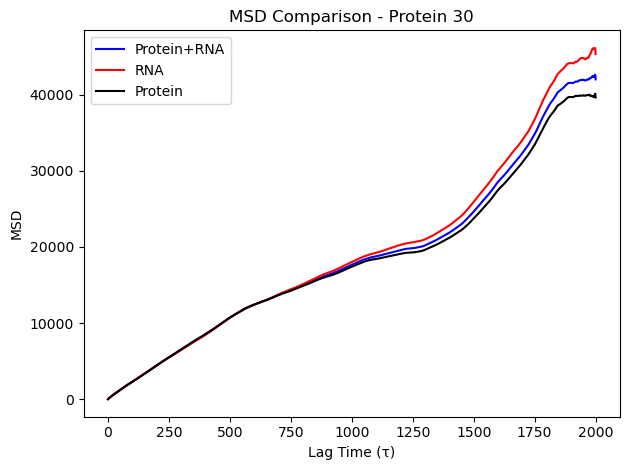

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import csv

msd_result_path = "results/msd/"
if not os.path.isdir(msd_result_path):
    os.makedirs(msd_result_path, exist_ok=True)

    
    


timestep = 1  # nanoseconds; adjust based on actual time between frames
# Plot each iteration separately
nframes2 = MSD_all.n_frames
lagtimes2 = np.arange(nframes2) * timestep

def write_into_csv(file_name, lagtimes, timeseries):    
    with open(f"{file_name}", "w") as file:
        writer = csv.writer(file)
        writer.writerow(["lag_frames", "MSD"])
        writer.writerows(
            [[lag, f"{msd:.4g}"] for lag, msd in zip(lagtimes, timeseries)]
        )
        
write_into_csv(f"{msd_result_path}protein_rna.csv", lagtimes2, MSD_all.results.timeseries)
write_into_csv(f"{msd_result_path}rna.csv", lagtimes2, MSD_rna.results.timeseries)
write_into_csv(f"{msd_result_path}prot.csv", lagtimes2, MSD_prot.results.timeseries)

fig, ax = plt.subplots()  # Create a new figure and axes for each iteration    
ax.plot(
    lagtimes2, 
    MSD_all.results.timeseries, 
    label=f'Protein+RNA', 
    linestyle="-", 
    color="blue"
)
ax.plot(
    lagtimes2, 
    MSD_rna.results.timeseries, 
    label=f'RNA', 
    linestyle="-", 
    color="red"
)
ax.plot(
    lagtimes2, 
    MSD_prot.results.timeseries, 
    label=f'Protein', 
    linestyle="-", 
    color="black"
)

# Add labels, legend, and show plot
ax.set_xlabel("Lag Time (τ)")
ax.set_ylabel("MSD")
ax.legend(loc='upper left')
ax.set_title(f"MSD Comparison - Protein {i + 1}")
plt.tight_layout()  # Adjust layout for better spacing
plt.show()  # Display the plot for this iteration

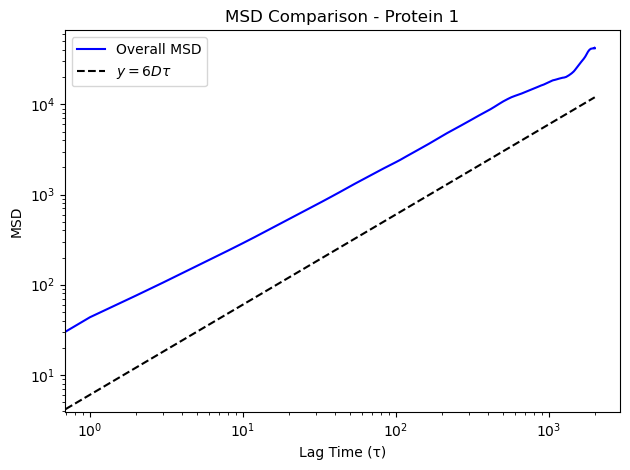

In [3]:
import numpy as np
import matplotlib.pyplot as plt

timestep = 1  # nanoseconds; adjust based on actual time between frames

# Plot each iteration separately
for i in range(1): # to see all proteins change back to 50
    nframes2 = MSD_all.n_frames
    lagtimes2 = np.arange(nframes2) * timestep

    # Create a new figure and axes for each iteration
    fig, ax = plt.subplots()  # Create a new figure and axes
    ax.set_xscale('log')  # Set x-axis to log scale
    ax.set_yscale('log')  # Set y-axis to log scale

    # Plot the current iteration
    # ax.plot(
    #     lagtimes2, 
    #     results[i], 
    #     label=f'Iteration {i + 1}', 
    #     linestyle="-", 
    #     color="red"
    # )
    
    # Plot the overall MSD
    ax.plot(
        lagtimes2, 
        MSD_all.results.timeseries, 
        label='Overall MSD', 
        linestyle="-", 
        color="blue"
    )

    # Plot the exact result for comparison
    exact = lagtimes2 * 6  # Replace with the actual expected result
    ax.plot(lagtimes2, exact, color="black", linestyle="--", label=r'$y=6D\tau$')

    # Add labels, legend, and show plot
    ax.set_xlabel("Lag Time (τ)")
    ax.set_ylabel("MSD")
    ax.legend(loc='upper left')
    ax.set_title(f"MSD Comparison - Protein {i + 1}")
    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()  # Display the plot for this iteration